# Wine Quality Analysis

<img src="https://thumbor.forbes.com/thumbor/fit-in/1200x0/filters%3Aformat%28jpg%29/https%3A%2F%2Fspecials-images.forbesimg.com%2Fdam%2Fimageserve%2F1133888244%2F0x0.jpg%3Ffit%3Dscale" width="600px" />

This notebook analyse a database of **red** and **white** variants of the Portuguese "Vinho Verde" wine based on wine **physicochemical test results** and quality scores that experts assign to each wine sample.

In [50]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_theme(style='whitegrid')

In [52]:
full_df = pd.read_csv('data/winequalityN.csv')

full_df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# Model

In [53]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, GridSearchCV, cross_val_predict
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.utils.multiclass import unique_labels

In [54]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

set_config(display='diagram')

In [55]:
def plot_confusion_matrix_by_predictions(y_true, y_predicted, *, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None, colorbar=False,
                          cmap='viridis', ax=None):
    
    cm = confusion_matrix(y_true, y_predicted, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_predicted)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format, colorbar=colorbar)


In [56]:
def score_classification_model(model, X_train, y_train):
    
    cv_scores = cross_validate(
        model, X_train, y_train, 
        scoring=['f1_weighted', 'balanced_accuracy'],
        cv=5,
        n_jobs=-1, verbose=0
    )

    cv_y_predicted = cross_val_predict(
        model, X_train, y_train,
        cv=5,
        n_jobs=-1
    )

    cv_f1_weighted, f1_weighted_std = cv_scores['test_f1_weighted'].mean(), cv_scores['test_f1_weighted'].std()
    cv_balanced_accuracy, balanced_accuracy_std = cv_scores['test_balanced_accuracy'].mean(), cv_scores['test_balanced_accuracy'].std()

    model.fit(X_train, y_train)

    y_train_predicted = model.predict(X_train)

    train_f1_weighted = f1_score(y_train, y_train_predicted, average='weighted')
    train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_predicted)

    print('[Train] F1 Weighted: %.4f' % (train_f1_weighted))
    print('[Train] Balanced Accuracy: %.4f' % (train_balanced_accuracy))
    print('Train Set Report:')
    print(classification_report(y_train, y_train_predicted))

    print('[CV] F1 Weighted: %.4f (%.4f)' % (cv_f1_weighted, f1_weighted_std))
    print('[CV] Balanced Accuracy: %.4f (%.4f)' % (cv_balanced_accuracy, balanced_accuracy_std))
    print('CV Report:')
    print(classification_report(y_train, cv_y_predicted))
    
    # display confusion matrixes

    _, (ax0, ax1) = plt.subplots(1, 2)

    ax0.set_title('Train Confusion Matrix')
    plot_confusion_matrix(
        model, X_train, y_train,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax0,
        colorbar=False,
    )

    ax1.set_title('CV Confusion Matrix')
    plot_confusion_matrix_by_predictions(
        y_train, cv_y_predicted,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax1,
        colorbar=False,
    )

In [57]:
# sklearn's pipeline API is limited at this point and doesn't provide a way to get columns of transformed X array
# This snippet will cover our back 

def get_columns_from_transformer(column_transformer, input_colums):    
    col_name = []

    for transformer_in_columns in column_transformer.transformers_[:-1]: #the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names(raw_col_name)
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)

    [_, _, reminder_columns] = column_transformer.transformers_[-1]

    for col_idx in reminder_columns:
        col_name.append(input_colums[col_idx])

    return col_name

## Test Dataset Distribution

## Feature Engineering

Feature Engineering:
- `total sulfur dioxide` - doesn't improve models in a raw view

In [90]:
model_features = [
    'type',
    'alcohol',
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'pH',
    'residual sugar',
    'free sulfur dioxide',
    'chlorides',
    'density',
]

X = full_df[model_features]
y = full_df['quality']

stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

for train_idx, test_idx in stratified_splitter.split(X, y):
    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]

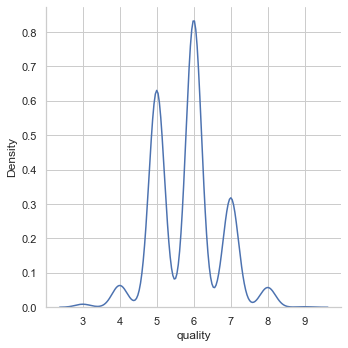

In [59]:
sns.displot(data=y_test, kind='kde')

In [60]:
y_test.value_counts()

6    567
5    428
7    216
4     43
8     39
3      6
9      1
Name: quality, dtype: int64

In [61]:
X_test['type'].value_counts()

white    967
red      333
Name: type, dtype: int64

## Data Processing

In [101]:
log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

numerical_scaler = Pipeline([
    ('imputing', SimpleImputer(strategy='median')),
    ('log_transforming', log_transformer),
])

featureTransformer = ColumnTransformer([
        ('feature_scaling', numerical_scaler, ['fixed acidity', 'chlorides', 'citric acid', 'volatile acidity']),
        ('feature_imputing', SimpleImputer(strategy='median'), [
            'pH', 'density', 'residual sugar',
        ]),
        ('wine_type_onehot', OneHotEncoder(), ['type']),
    ],
    remainder='passthrough'
)

## LogisticRegression

In [102]:
logistic_regression = LogisticRegression(
    solver='liblinear',
    penalty='l1',
    C=1,
    max_iter=2000,
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

logistic_regression_pipeline = Pipeline([
    ('feature_processing', featureTransformer),
    ('quality_classification', logistic_regression),
])

logistic_regression_pipeline

## F1 Weighted: 0.2895 (0.0135), Balanced Accuracy: 0.3349 (0.0429)
# solver='lbfgs',
# C=0.95,
# max_iter=2000,
# class_weight='balanced'

## F1 Weighted: 0.4395 (0.0177), Balanced Accuracy: 0.3591 (0.0586)
# solver='liblinear',
# penalty='l1',
# C=1,
# max_iter=2000,
# class_weight='balanced'

Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feature_scaling',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transforming',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>))]),
                                                  ['fixed acidity', 'chlorides',
                                                   'citric acid',
                                                   'volatile acidity']),
                                                 ('feature_imputing',
                                                  SimpleImputer(strategy='median'),
                                                  ['pH', 'density',
                                                   'residual sugar']),
                                                 ('wine_type_onehot',
                                                  OneHotEncoder(),
                                                  ['type'])])),
                ('quality_classification',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=2000,
                                    n_jobs=-1, penalty='l1', random_state=42,
                                    solver='liblinear'))])

[Train] F1 Weighted: 0.4799
[Train] Balanced Accuracy: 0.4587
Train Set Report:
              precision    recall  f1-score   support

           3       0.03      0.21      0.05        24
           4       0.21      0.40      0.28       173
           5       0.58      0.60      0.59      1710
           6       0.55      0.43      0.48      2269
           7       0.37      0.35      0.36       863
           8       0.16      0.21      0.19       154
           9       0.03      1.00      0.06         4

    accuracy                           0.47      5197
   macro avg       0.28      0.46      0.29      5197
weighted avg       0.50      0.47      0.48      5197

[CV] F1 Weighted: 0.4776 (0.0141)
[CV] Balanced Accuracy: 0.3664 (0.0672)
CV Report:
              precision    recall  f1-score   support

           3       0.02      0.17      0.04        24
           4       0.20      0.36      0.26       173
           5       0.57      0.60      0.58      1710
           6       0.

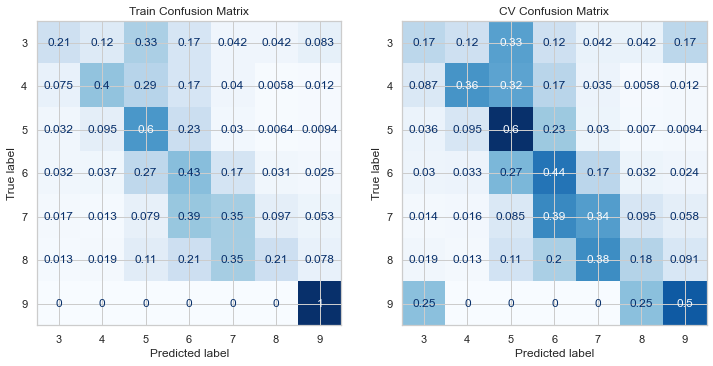

In [103]:
score_classification_model(logistic_regression_pipeline, X_train, y_train)

### Hyperparam Tuning

In [65]:
parameters = {
    'quality_classification__penalty': ['l2', 'l1', 'elasticnet', 'none'], # 'l1', 'elasticnet', 'none'
    'quality_classification__C': [1.0, 0.95, 0.9, 0.8], # 1.0
    'quality_classification__tol': [1e-4],
    'quality_classification__class_weight': ['balanced'],
    'quality_classification__solver': ['lbfgs', 'liblinear', 'sag', 'saga'], # lbfgs
    'quality_classification__max_iter': [2000, 2500],
    'quality_classification__l1_ratio': [1.0, 0.0, 0.3, 0.4, 0.5],
}

param_searcher = GridSearchCV(
   estimator=logistic_regression_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

#param_searcher.fit(X_train, y_train)
#param_searcher.best_params_, param_searcher.best_score_

## GradientBoostingClassifier

In [104]:
hgb_classifier = HistGradientBoostingClassifier(
    learning_rate=0.15,
    l2_regularization=0.15,
    max_iter=350,
    max_leaf_nodes=20,
    min_samples_leaf=10,
    random_state=RANDOM_SEED,
)

hgb_pipeline = Pipeline([
    ('feature_processing', featureTransformer),
    ('quality_classification', hgb_classifier),
])

hgb_pipeline

## F1 Weighted: 0.6279 (0.0141), Balanced Accuracy: 0.3590 (0.0309)
#learning_rate=0.15,
#l2_regularization=0.1,
#max_iter=300

Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feature_scaling',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transforming',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>))]),
                                                  ['fixed acidity', 'chlorides',
                                                   'citric acid',
                                                   'volatile acidity']),
                                                 ('feature_imputing',
                                                  SimpleImputer(strategy='median'),
                                                  ['pH', 'density',
                                                   'residual sugar']),
                                                 ('wine_type_onehot',
                                                  OneHotEncoder(),
                                                  ['type'])])),
                ('quality_classification',
                 HistGradientBoostingClassifier(l2_regularization=0.15,
                                                learning_rate=0.15,
                                                max_iter=350, max_leaf_nodes=20,
                                                min_samples_leaf=10,
                                                random_state=42))])

[Train] F1 Weighted: 1.0000
[Train] Balanced Accuracy: 1.0000
Train Set Report:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00       173
           5       1.00      1.00      1.00      1710
           6       1.00      1.00      1.00      2269
           7       1.00      1.00      1.00       863
           8       1.00      1.00      1.00       154
           9       1.00      1.00      1.00         4

    accuracy                           1.00      5197
   macro avg       1.00      1.00      1.00      5197
weighted avg       1.00      1.00      1.00      5197

[CV] F1 Weighted: 0.6307 (0.0194)
[CV] Balanced Accuracy: 0.3580 (0.0325)
CV Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00        24
           4       0.50      0.16      0.24       173
           5       0.67      0.68      0.67      1710
           6       0.

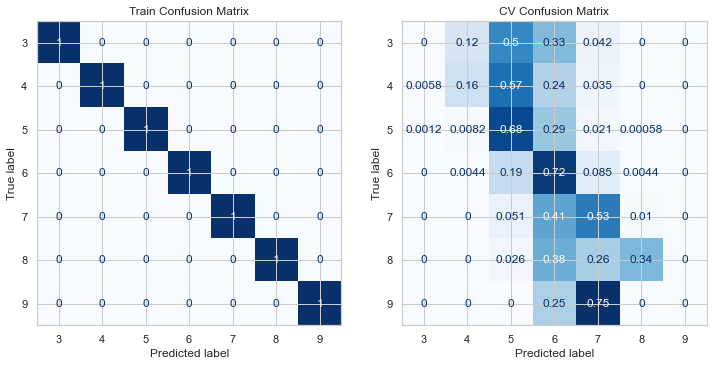

In [105]:
score_classification_model(hgb_pipeline, X_train, y_train)

### Hyperparam Tuning

In [68]:
parameters = [
    {
        'quality_classification__learning_rate': [0.15],
        'quality_classification__l2_regularization': [0.1, 0.15, 0.2], #0.0
        'quality_classification__max_iter': [300, 350], # 100
        'quality_classification__max_leaf_nodes': [31, 20],
        'quality_classification__min_samples_leaf': [20, 10, 5],
        'quality_classification__max_depth': [None],
    },
]

param_searcher = GridSearchCV(
   estimator=hgb_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

#param_searcher.fit(X_train, y_train)
#param_searcher.best_params_, param_searcher.best_score_

## RandomForest

In [106]:
rf_classifier = RandomForestClassifier(
    criterion='gini',
    n_estimators=15,
    min_samples_split=20,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=RANDOM_SEED,
)

rf_pipeline = Pipeline([
    ('feature_processing', featureTransformer),
    ('quality_classification', rf_classifier),
])

rf_pipeline

## F1 Weighted: 0.5088 (0.0184), Balanced Accuracy: 0.3559 (0.0344)
# criterion='entropy',
# n_estimators=6,
# min_samples_split=20,
# min_samples_leaf=4,
# max_features='log2',
# class_weight='balanced',

## F1 Weighted: 0.5569 (0.0059), Balanced Accuracy: 0.3953 (0.0366)
# criterion='gini',
# n_estimators=15,
# min_samples_split=20,
# min_samples_leaf=1,
# max_features='sqrt',
# class_weight='balanced',

Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feature_scaling',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transforming',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>))]),
                                                  ['fixed acidity', 'chlorides',
                                                   'citric acid',
                                                   'volatile acidity']),
                                                 ('feature_imputing',
                                                  SimpleImputer(strategy='median'),
                                                  ['pH', 'density',
                                                   'residual sugar']),
                                                 ('wine_type_onehot',
                                                  OneHotEncoder(),
                                                  ['type'])])),
                ('quality_classification',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='sqrt',
                                        min_samples_split=20, n_estimators=15,
                                        random_state=42))])

[Train] F1 Weighted: 0.7860
[Train] Balanced Accuracy: 0.9083
Train Set Report:
              precision    recall  f1-score   support

           3       0.73      1.00      0.84        24
           4       0.68      0.97      0.80       173
           5       0.80      0.82      0.81      1710
           6       0.87      0.69      0.77      2269
           7       0.68      0.91      0.78       863
           8       0.65      0.97      0.78       154
           9       1.00      1.00      1.00         4

    accuracy                           0.79      5197
   macro avg       0.77      0.91      0.83      5197
weighted avg       0.80      0.79      0.79      5197

[CV] F1 Weighted: 0.5640 (0.0094)
[CV] Balanced Accuracy: 0.3760 (0.0265)
CV Report:
              precision    recall  f1-score   support

           3       0.08      0.08      0.08        24
           4       0.22      0.27      0.24       173
           5       0.63      0.66      0.64      1710
           6       0.

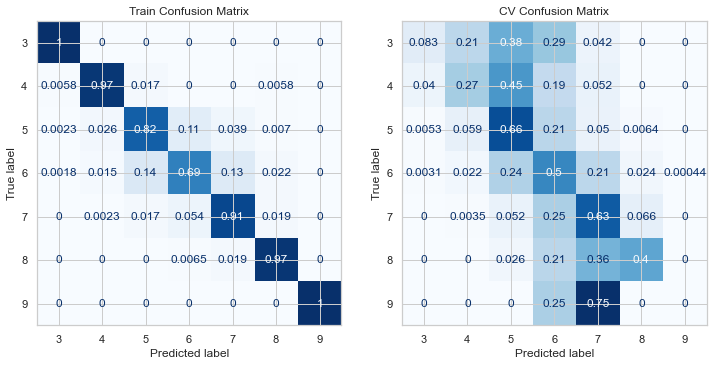

In [107]:
score_classification_model(rf_pipeline, X_train, y_train)

### Hyperparam Tuning

In [71]:
parameters = {
    'quality_classification__n_estimators': [10, 15, 20],
    'quality_classification__criterion': ['gini', 'entropy'],
    'quality_classification__max_features': [None, 'sqrt', 'log2', 'auto'],
    'quality_classification__max_depth': [None], # 3, 4, 5
    'quality_classification__min_samples_split': [15, 20, 25], # 2
    'quality_classification__min_samples_leaf': [1, 2, 4, 5], # 2
    'quality_classification__class_weight': ['balanced'],
}

param_searcher = GridSearchCV(
   estimator=rf_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

#param_searcher.fit(X_train, y_train)
#param_searcher.best_params_, param_searcher.best_score_

## Model Inspection

In [99]:
X_train_processed_columns = get_columns_from_transformer(rf_pipeline.named_steps['feature_processing'], list(X_train.columns))

In [108]:
features_list = sorted(zip(rf_pipeline.named_steps['quality_classification'].feature_importances_, X_train_processed_columns), reverse=True)
features_list

[(0.19056089757579456, 'alcohol'),
 (0.12428419692967559, 'volatile acidity'),
 (0.11718445593576925, 'free sulfur dioxide'),
 (0.11095938407125448, 'density'),
 (0.10707011599759361, 'chlorides'),
 (0.08941257367715387, 'citric acid'),
 (0.08674511911727008, 'pH'),
 (0.08252477252054856, 'residual sugar'),
 (0.081115786423474, 'fixed acidity'),
 (0.006644511874528783, 'type_red'),
 (0.0034981858769372346, 'type_white')]

In [74]:
# from eli5.sklearn import PermutationImportance
# from eli5 import show_weights

# X_train_processed = rf_pipeline.named_steps['feature_processing'].transform(X_train)

# permutation_importance = PermutationImportance(
#     rf_classifier, 
#     scoring='balanced_accuracy',
#     #cv=5,
#     random_state=RANDOM_SEED,
# )

# permutation_importance.fit(X_train_processed, y_train)
# show_weights(permutation_importance, feature_names=X_train_processed_columns, top=20)